In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Embedding, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import numpy as np
import pydot
import tensorflow as tf
import pickle
import string
import time
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pickle import dump
from unicodedata import normalize
from numpy import array
DATASET_PATH = "path/file"

In [ ]:
# load doc into memory
def load_doc(filename, n):
    # open the file as read only
    file = open(filename, mode= 'rt' , encoding= 'utf-8')
    # read all text
    text = file.read().strip().split('\n')
    text = [line.split('\t') for line in text]
    text = [[line[0],line[1]] for line in text] # first language and second language/Question and Answer/Text and summary
    text = text[:n]
    # close the file
    file.close()
    return text

In [ ]:
# Process the data file
def process_pairs(line):
#    line = ' '.join(line)
    line = line.lower().strip()
    line = normalize('NFD' , line).encode('ascii' , 'ignore')
    line = line.decode('UTF-8')
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ",line)
    line = line.strip()
    line = '<start> ' + line + ' <end>'
    return line

In [ ]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    padded = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return padded, lang_tokenizer

In [ ]:
Numb = 30000 # number of data lines
doc = load_doc(DATASET_PATH, Numb)
first_language = []
second_language = []
for text in doc:
    first_language.append(process_pairs(text[1]))
    second_language.append(process_pairs(text[0]))
len(doc)

30000

In [ ]:
first_language[-10]

'<start> vamos a divertirnos mucho . <end>'

In [ ]:
input_padded, inp_tokenizer = tokenize(first_language)
target_padded, targ_tokenizer = tokenize(second_language)
max_length_targ, max_length_inp = target_padded.shape[1], input_padded.shape[1]
max_length_targ, max_length_inp

(11, 16)

In [ ]:
start_tk = targ_tokenizer.word_index['<start>']
end_tk = targ_tokenizer.word_index['<end>']
start_tk,end_tk

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_padded, target_padded, test_size=0.1)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

27000 27000 3000 3000


In [ ]:
BUFFER_SIZE = len(first_language)
BATCH_SIZE = 64
steps_per_epoch = len(first_language)//BATCH_SIZE
embedding_dim = 256
units = 1024
dropout=0.0
beam_widt = 3
vocab_inp_size = len(inp_tokenizer.word_index)+1
vocab_tar_size = len(targ_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

input_padded.shape

(30000, 16)

In [ ]:
BUFFER_SIZE_TEST = len(input_tensor_val)
dataset_test = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE_TEST)
dataset_test = dataset_test.batch(1)
asd=[]
for i,j in dataset_test:
    asd.append(i)
len(asd)

## Encoder

In [ ]:
class encoder(tf.keras.Model):
    def __init__(self, units, BATCH_SIZE, vocab_size, embedding_dim, dropout):
        super(encoder, self).__init__()
        self.BATCH_SIZE = BATCH_SIZE
        self.units = units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.pre_GRU = Bidirectional(GRU(self.units, return_sequences=True, return_state = True, recurrent_initializer='glorot_uniform',
                                   dropout = self.dropout), merge_mode='concat')
        self.embedding = Embedding(self.vocab_size, self.embedding_dim)
        self.relu = Dense(self.units, activation='relu')

    def call(self, X, s_state):
        X = self.embedding(X)
        enc_output, forward_, backward_ = self.pre_GRU(X, initial_state=s_state)
        hidden_states = tf.concat([forward_, backward_], axis=1)
        s_state = self.relu(hidden_states)
        return enc_output, s_state

    def initialize_hidden_state(self):
        return [tf.zeros((self.BATCH_SIZE, self.units)) for i in range(2)]

In [ ]:
encoder = encoder(units, BATCH_SIZE, vocab_inp_size, embedding_dim, dropout)

## Attention Decorder

In [ ]:
class SeqAttentionDecoder(tf.keras.Model):
    def __init__(self, vocab_out, units, embedding_dim, dropout):
        super(SeqAttentionDecoder, self).__init__()
        self.units = units
        self.max_length_inp = max_length_inp
        self.vocab_out = vocab_out
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.post_activation_GRU_cell = GRU(self.units, return_state = True, return_sequences=True, recurrent_initializer='glorot_uniform',dropout = self.dropout)
        self.output_layer = Dense(self.vocab_out, activation='softmax')
        self.embedding = Embedding(vocab_out, embedding_dim)
        self.W1 = Dense(self.units)
        self.W2 = Dense(self.units)
        self.V = Dense(1)
    def call(self,x, enc_output, s_state):
        
        query = s_state 
        values = enc_output

        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1) 
        
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        dec_output, s_state = self.post_activation_GRU_cell(x, initial_state = s_state)
        dec_output = tf.reshape(dec_output, (-1, dec_output.shape[2]))
        out = self.output_layer(dec_output)
        return out,s_state, attention_weights

In [ ]:
decoder = SeqAttentionDecoder(vocab_tar_size, units, embedding_dim, dropout)

In [ ]:
EPOCHS = 10

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_fn(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(x_batch_train, y_batch_train, s_state):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, s_state = encoder(x_batch_train, s_state)
        dec_input = tf.expand_dims([start_tk]*BATCH_SIZE, 1)
        for t in range(1,y_batch_train.shape[1]):
            
            predictions, s_state , attention_weights = decoder(dec_input, enc_output, s_state)   
            loss+= loss_fn(y_batch_train[:,t], predictions)
            dec_input = tf.expand_dims(y_batch_train[:, t], 1)
            
    batch_loss = (loss / y_batch_train.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    s0 = encoder.initialize_hidden_state()
    total_loss = 0
    for step, (x_batch_train, y_batch_train) in enumerate(dataset):
            batch_loss = train_step(x_batch_train, y_batch_train, s0)
            total_loss += batch_loss
    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Loss 1.7872
Time taken for 1 epoch 48.62 sec

Epoch 2 Loss 1.0327
Time taken for 1 epoch 37.42 sec

Epoch 3 Loss 0.6401
Time taken for 1 epoch 37.52 sec

Epoch 4 Loss 0.3914
Time taken for 1 epoch 37.47 sec

Epoch 5 Loss 0.2427
Time taken for 1 epoch 37.43 sec

Epoch 6 Loss 0.1557
Time taken for 1 epoch 37.40 sec

Epoch 7 Loss 0.1088
Time taken for 1 epoch 37.44 sec

Epoch 8 Loss 0.0822
Time taken for 1 epoch 37.36 sec

Epoch 9 Loss 0.0694
Time taken for 1 epoch 37.34 sec

Epoch 10 Loss 0.0626
Time taken for 1 epoch 37.35 sec



## Beam Search

In [ ]:
# Beam search implementation
import operator
def beam_search(sentence, beam_width = beam_widt,  verbose=True):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = sentence

    summary = ''

    s_state = [tf.zeros((1, units)) for i in range(2)] #BiRNN

    enc_output, s_state = encoder(inputs, s_state)

    dec_hidden = s_state
    dec_input = tf.expand_dims([start_tk], 0)
    
    # initial beam with (tokens, last hidden state, attn, score)
    start_pt = [([start_tk], dec_hidden, attention_plot, 0.0)]  # initial beam 
    
    for t in range(max_length_targ):
        options = list() # empty list to store candidates
        for row in start_pt:
            # handle beams emitting end signal
            allend = True
            dec_input = row[0][-1]
            if dec_input != end_tk:
                dec_input = tf.expand_dims([dec_input], 0)  # last token
    
                dec_hidden = row[1]  # second item is hidden states
                attention_plot = np.zeros((max_length_targ, max_length_inp)) +\
                           row[2] # new attn vector
                predictions, dec_hidden , attention_weights = decoder(dec_input, enc_output, dec_hidden)
          
                # storing the attention weights to plot later on
                attention_weights = tf.reshape(attention_weights, (-1, ))
                attention_plot[t] = attention_weights.numpy() 
                
                # take top-K in this beam
                values, indices = tf.math.top_k(predictions[0], k=beam_width)
                for tokid, scre in zip(indices.numpy(), values.numpy()):
                    score = row[3] - np.log(scre)
                    options.append((row[0]+[tokid], dec_hidden, attention_plot, score))
                allend=False
            else:
                options.append(row)  # add ended beams back in
        if allend:
            break # end for loop as all sequences have ended
        start_pt = sorted(options, key=operator.itemgetter(3))[:beam_width]
    for x in start_pt[0][0][1:]:
        summary += targ_tokenizer.index_word[x] + ' '
        if x == end_tk:
            break
    attention_plot = start_pt[0][2]  # third item in tuple
    return summary, attention_plot

## Greedy Search

In [ ]:
def greedy_search(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    inputs = sentence

    result = ''
    
    
    s_state = [tf.zeros((1, units)) for i in range(2)] #BiRNN

    enc_output, s_state = encoder(inputs, s_state)

    dec_input = tf.expand_dims([start_tk], 0)

    for t in range(max_length_targ):

        predictions, s_state , attention_weights = decoder(dec_input, enc_output, s_state)

    # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_tokenizer.index_word[predicted_id] + ' '
        if predicted_id == end_tk:
            return result, attention_plot
    # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate_sentence(sentenceX, greedy=True, beam_widt =beam_widt):

    sentence = process_pairs(sentenceX)
    inputs = [inp_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    if greedy == True:
        result, attention_plot = greedy_search(inputs)
    else :
        result, attention_plot = beam_search(inputs, beam_width=beam_widt)


    print('Input:', sentence)
    print('Predicted translation:', result)
    attention_plot = attention_plot[:len(result.split(' ')),    :len(sentence.split(' '))]

    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


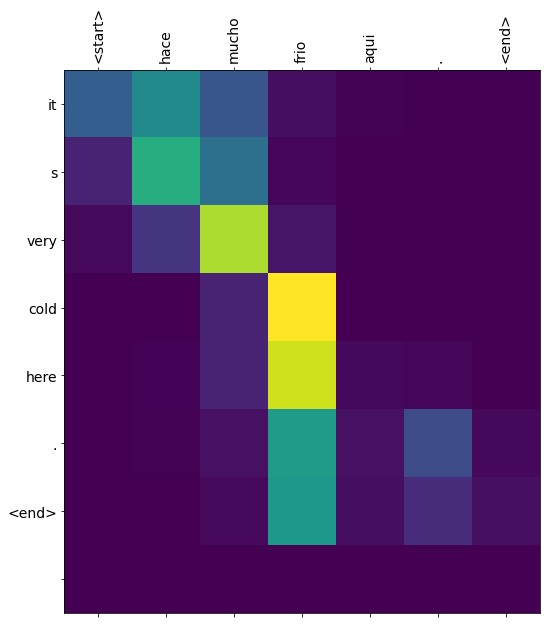

In [ ]:
translate_sentence(u'hace mucho frio aqui.', greedy = False)

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


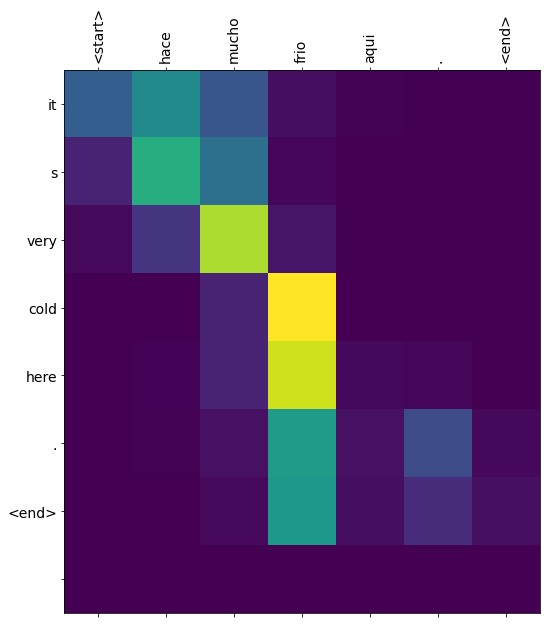

In [ ]:
translate_sentence(u'hace mucho frio aqui .', greedy = True)

##  Bleu Score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
def evaluate_bleu_score(dataset_test, greedy =True):
    bleu_scores = {
        "score": [],
        "length": [],
    }
    smooth_fn = SmoothingFunction()

    for num, (encoder_in, decoder_out) in enumerate(dataset_test):

        length = len([i for i in encoder_in[0].numpy() if i > 0])-2 # remove start and end value
        # Greedy search and Beam search
        if  greedy == True:
          decoder_pred, _ = greedy_search(encoder_in)
        else :
          decoder_pred, _ = beam_search(encoder_in)

        ref_sent = [targ_tokenizer.index_word[i] for i in decoder_out.numpy()[0] if i > 0]
        hyp_sent  = [i for i in decoder_pred.split()]


        hyp_sent = hyp_sent[:-1] 

        ref_sent = ref_sent[1:-1]

        bleu_scorex = sentence_bleu([ref_sent], hyp_sent, smoothing_function=smooth_fn.method1)

        bleu_scores["score"].append(bleu_scorex)
        bleu_scores["length"].append(length)

    asd = pd.DataFrame(data=bleu_scores)
    asd = asd.groupby(['length']).mean()

    return asd

In [ ]:
# data_greedy = evaluate_bleu_score(dataset_test)
# data_greedy = data_greedy.reset_index()

In [ ]:
# data_beam = evaluate_bleu_score(dataset_test, greedy = False)
# data_beam = data_beam.reset_index()

In [ ]:
# ax = plt.gca()
# data_greedy.plot(x ='length', y='score', ax=ax, label = 'greedy')
# data_beam.plot(x ='length', y='score', ax =ax, label = 'beam')
# plt.show()